# **Description**

**Customer segmentation is the practice of dividing a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits.**

**Companies employing customer segmentation operate under the fact that every customer is different and that their marketing efforts would be better served if they target specific, smaller groups with messages that those consumers would find relevant and lead them to buy something. Companies also hope to gain a deeper understanding of their customers' preferences and needs with the idea of discovering what each segment finds most valuable to more accurately tailor marketing materials toward that segment.**

**Now, we'll divide the customers behaviours with unsupervised learning algorithms such as K-means clustering, Hierarchical clustering, DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

# **Information about Dataset**

* master_id: Unique client number
* order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)
* last_order_channel: The channel where the last purchase was made
* first_order_date: The date of the first purchase made by the customer
* last_order_date: The date of the customer's last purchase
* last_order_date_online: The date of the last purchase made by the customer on the online platform
* last_order_date_offline: The date of the last purchase made by the customer on the offline platform
* order_num_total_ever_online: The total number of purchases made by the customer on the online platform
* order_num_total_ever_offline: Total number of purchases made by the customer offline
* customer_value_total_ever_offline: The total price paid by the customer for offline purchases
* customer_value_total_ever_online: The total price paid by the customer for their online shopping
* interested_in_categories_12: List of categories the customer has purchased from in the last 12 months

# 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans      # K-Means
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer     # Elbow method 
from scipy.cluster.hierarchy import linkage, dendrogram  # hierarchical clustering
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering     # hierarchical clustering

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import warnings 
warnings.simplefilter(action='ignore', category=Warning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flo-data/flo_data_20k.csv


# 2. First Check to Dataset

In [2]:
df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

**RFM Analaysis of the Data**

In [5]:
df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

# 3. Seperate/Analyse Cat_Cols, Num_Cols, Correlation Matrix

**Firstly, we write down functions which needed for this kind of analysis**

In [6]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [7]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
Note: Categorical variables with numerical appearance are also included in categorical variables.

     parameters
     ------
         dataframe: dataframe
                 The dataframe from which variable names are to be retrieved
         cat_th: int, optional
                 class threshold for numeric but categorical variables
         car_th: int, optinal
                 class threshold for categorical but cardinal variables

     Returns
     ------
         cat_cols: list
                 Categorical variable list
         num_cols: list
                 Numeric variable list
         cat_but_car: list
                 Categorical view cardinal variable list

     Examples
     ------
         import seaborn as sns
         df = sns.load_dataset("iris")
         print(grab_col_names(df))


     notes
     ------
         cat_cols + num_cols + cat_but_car = total number of variables
         num_but_cat is inside cat_cols.
         The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
     
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    print(cat_cols)
    print(num_cols)
    print(cat_but_car)

**Determining cat_cols, num_cols via using defined functions**

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [10]:
for col in cat_cols:
    cat_summary(df, col)

             order_channel      Ratio
Android App           9495  47.605916
Mobile                4882  24.477313
Ios App               2833  14.204061
Desktop               2735  13.712710
##########################################
             last_order_channel      Ratio
Android App                6783  34.008523
Offline                    6608  33.131111
Mobile                     3172  15.903735
Ios App                    1696   8.503384
Desktop                    1686   8.453246
##########################################


In [11]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13
tenure,19945.0,1380.302833,523.396883,584.00,1096.00,1230.00,1415.00,3639.00
recency,19945.0,713.458360,103.281149,581.00,622.00,690.00,781.00,946.00
frequency,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.00
monetary,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.10
order_num_total,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.00
customer_value_total,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.10


count    19945.000000
mean         3.110855
std          4.225647
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%          7.000000
95%         10.000000
99%         20.000000
max        200.000000
Name: order_num_total_ever_online, dtype: float64


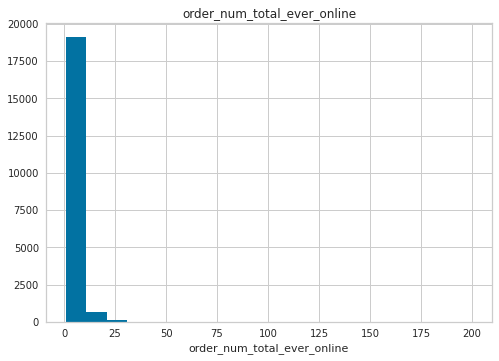

count    19945.000000
mean         1.913913
std          2.062880
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          2.000000
70%          2.000000
80%          3.000000
90%          4.000000
95%          4.000000
99%          7.000000
max        109.000000
Name: order_num_total_ever_offline, dtype: float64


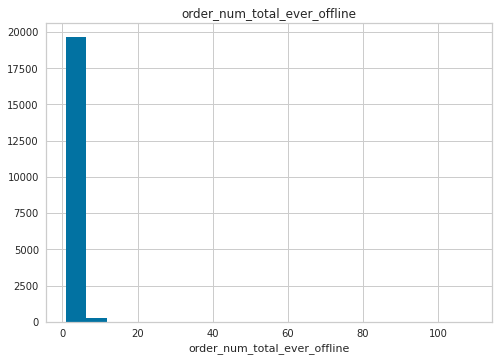

count    19945.000000
mean       253.922597
std        301.532853
min         10.000000
5%          39.990000
10%         59.990000
20%         89.980000
30%        110.480000
40%        140.230000
50%        179.980000
60%        220.860000
70%        281.868000
80%        365.058000
90%        519.950000
95%        694.222000
99%       1219.946800
max      18119.140000
Name: customer_value_total_ever_offline, dtype: float64


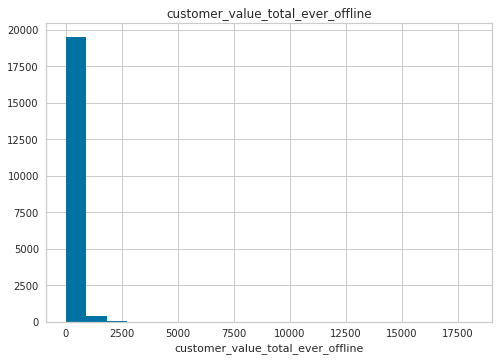

count    19945.000000
mean       497.321690
std        832.601886
min         12.990000
5%          63.990000
10%         84.990000
20%        125.990000
30%        173.970000
40%        219.990000
50%        286.460000
60%        371.944000
70%        491.526000
80%        690.868000
90%       1082.036000
95%       1556.726000
99%       3143.810400
max      45220.130000
Name: customer_value_total_ever_online, dtype: float64


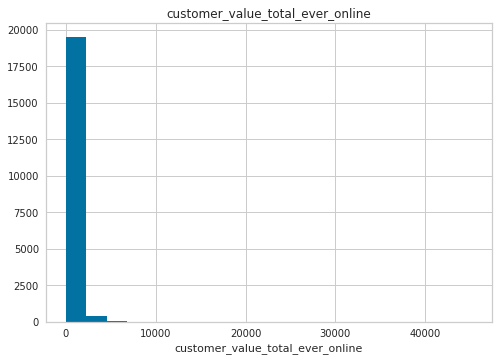

count    19945.000000
mean      1380.302833
std        523.396883
min        584.000000
5%         788.200000
10%        917.000000
20%       1057.000000
30%       1128.000000
40%       1179.000000
50%       1230.000000
60%       1309.000000
70%       1393.000000
80%       1546.200000
90%       2123.000000
95%       2653.000000
99%       3184.000000
max       3639.000000
Name: tenure, dtype: float64


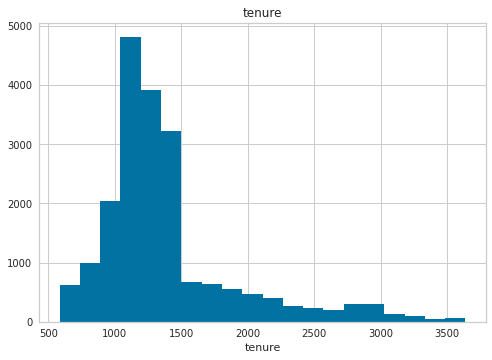

count    19945.000000
mean       713.458360
std        103.281149
min        581.000000
5%         588.000000
10%        595.000000
20%        612.000000
30%        635.000000
40%        662.000000
50%        690.000000
60%        724.000000
70%        765.000000
80%        811.000000
90%        887.000000
95%        914.000000
99%        939.000000
max        946.000000
Name: recency, dtype: float64


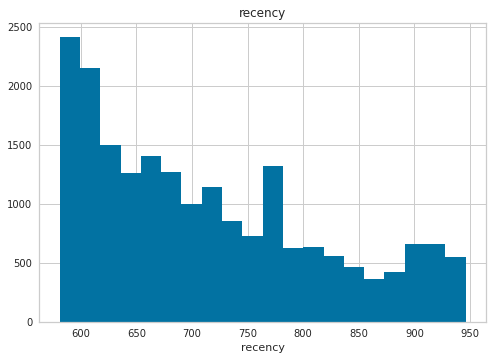

count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: frequency, dtype: float64


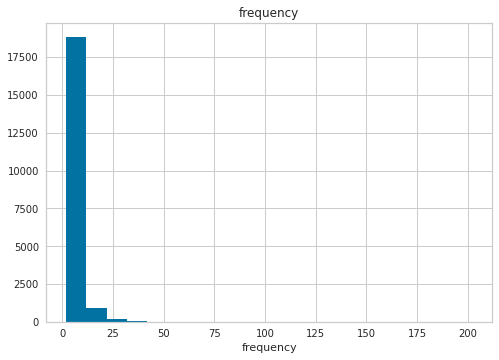

count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: monetary, dtype: float64


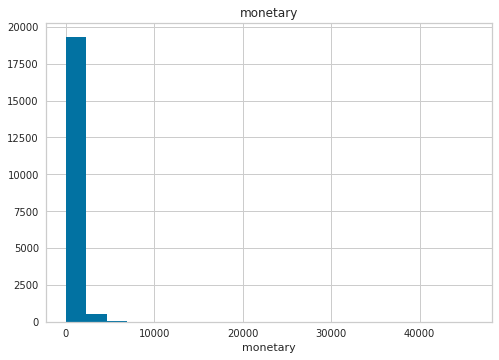

count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: order_num_total, dtype: float64


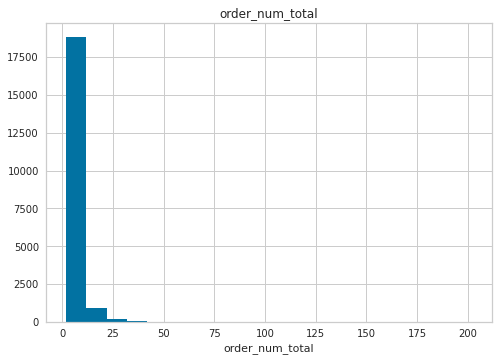

count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: customer_value_total, dtype: float64


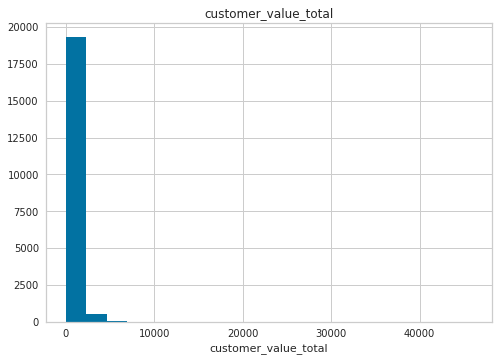

In [12]:
for col in num_cols:
     num_summary(df, col, plot=True)

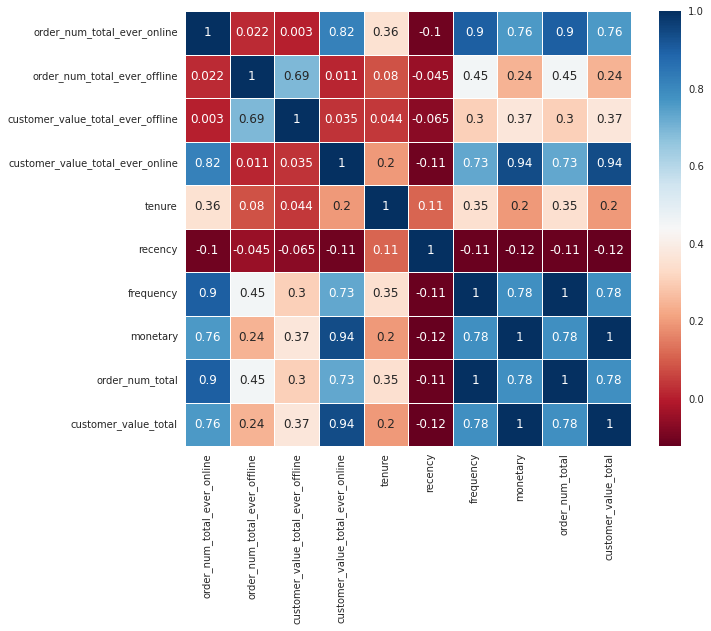

In [13]:
correlation_matrix(df, num_cols)

# 4. Feature Engineering Part

**Missing Values Analysis**

> **First define a function**

In [14]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [15]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


**Outlier Threshold Finding and Solve the Problems**

In [16]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if
            25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [18]:
for col in cat_cols:
    cat_summary(df, col)

   order_channel_Desktop     Ratio
0                  17210  86.28729
1                   2735  13.71271
##########################################
   order_channel_Ios App      Ratio
0                  17112  85.795939
1                   2833  14.204061
##########################################
   order_channel_Mobile      Ratio
0                 15063  75.522687
1                  4882  24.477313
##########################################
   last_order_channel_Desktop      Ratio
0                       18259  91.546754
1                        1686   8.453246
##########################################
   last_order_channel_Ios App      Ratio
0                       18249  91.496616
1                        1696   8.503384
##########################################
   last_order_channel_Mobile      Ratio
0                      16773  84.096265
1                       3172  15.903735
##########################################
   last_order_channel_Offline      Ratio
0                

In [19]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13
tenure,19945.0,1380.302833,523.396883,584.00,1096.00,1230.00,1415.00,3639.00
recency,19945.0,713.458360,103.281149,581.00,622.00,690.00,781.00,946.00
frequency,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.00
monetary,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.10
order_num_total,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.00
customer_value_total,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.10


# 5. K-Means

In [20]:
sc = StandardScaler()
X = sc.fit_transform(df[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508


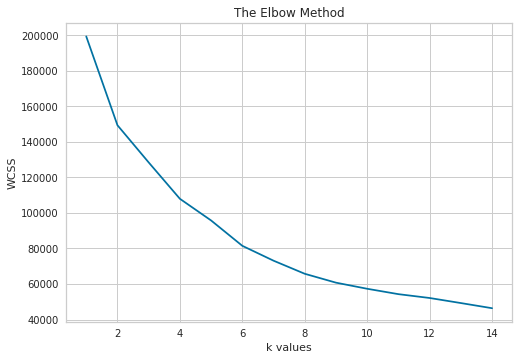

In [21]:
wcss = []  # We created a list to hold WCSS values.
for k in range(1, 15):  # We looped the numbers from 1 to 15.
    kmeans = KMeans(n_clusters=k).fit(X)  # We ran the K-Means algorithm.
    wcss.append(kmeans.inertia_)  # We added the WCSS values to the wcss list.

plt.plot(range(1, 15), wcss, 'bx-')  # We plotted the WCSS values.
plt.xlabel('k values')
plt.ylabel('WCSS')  
plt.title('The Elbow Method')  
plt.show() 

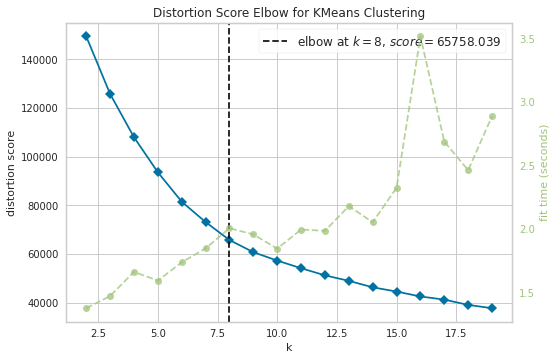

8

In [22]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show(block=True)

elbow.elbow_value_

In [23]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, init='k-means++').fit(X)
kmeans.cluster_centers_  # Indicates the centers of clusters.

array([[ 0.06449313, -0.04205883, -0.06119604, -0.12440353,  2.28947782,
         0.2909666 ,  0.03916811, -0.1362865 ,  0.03916811, -0.1362865 ],
       [-0.31390262, -0.19635108, -0.23088535, -0.25598321, -0.24846341,
         1.17419333, -0.36508483, -0.3157817 , -0.36508483, -0.3157817 ],
       [ 1.20237062, -0.05715613, -0.09943633,  1.0430893 ,  0.41108178,
        -0.34258371,  1.04642507,  0.9364449 ,  1.04642507,  0.9364449 ],
       [-0.28140911, -0.1841967 , -0.19355658, -0.22555646, -0.44289047,
        -0.63823744, -0.33084718, -0.27491825, -0.33084718, -0.27491825],
       [20.32618901, -0.16602674,  0.860791  , 32.33279837,  1.6305654 ,
        -0.8910832 , 18.03796981, 30.3549695 , 18.03796981, 30.3549695 ],
       [ 4.1679002 ,  0.29687515,  0.22991251,  3.35815899,  1.45246609,
        -0.40383178,  3.84263517,  3.20005442,  3.84263517,  3.20005442],
       [-0.14491574,  1.4370054 ,  1.73172771, -0.09491635, -0.03802152,
        -0.29622686,  0.49592085,  0.49491199

In [24]:
kmeans.inertia_

65755.36047001691

In [25]:
clusters_kmeans = kmeans.labels_ 
X["cluster"] = clusters_kmeans
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,3
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,5
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,1
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,3
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,3


In [26]:
X.groupby('cluster').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster').agg(['mean', 'median', 'count', 'std']).T
X['cluster'] = X['cluster'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,4
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,6
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,2
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,4
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,4


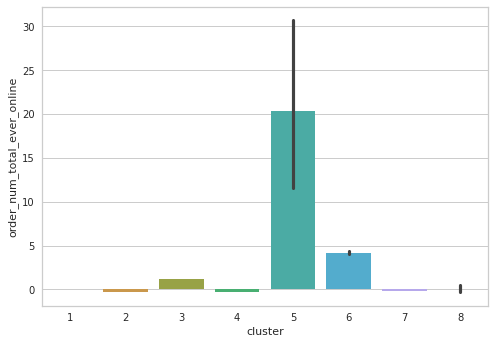

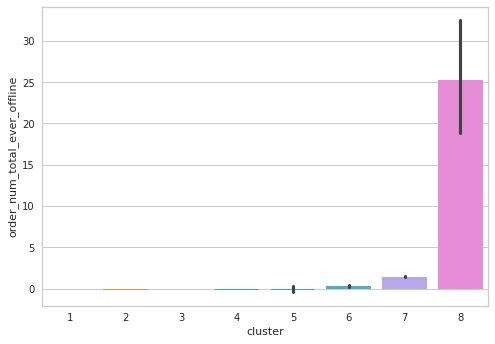

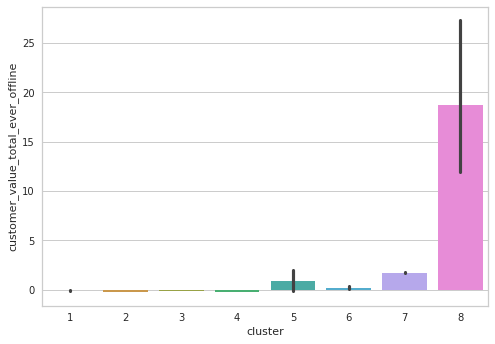

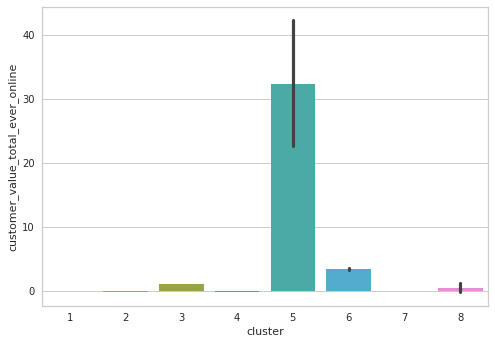

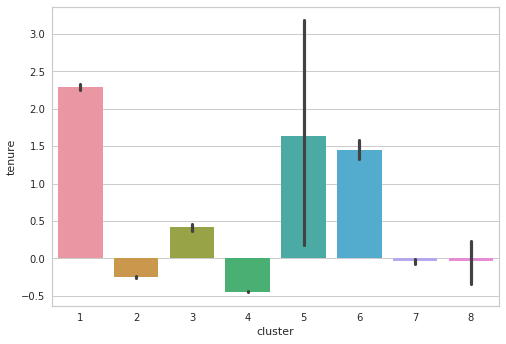

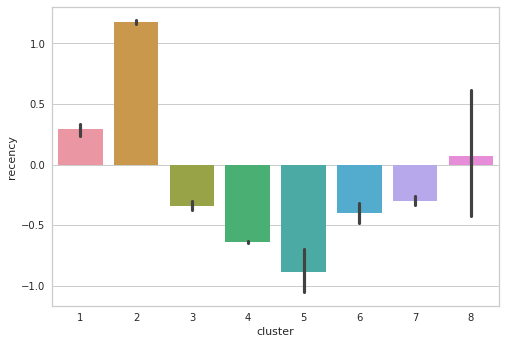

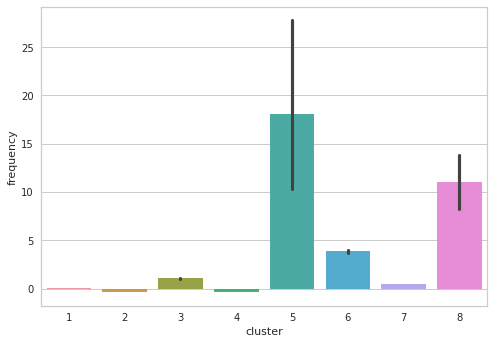

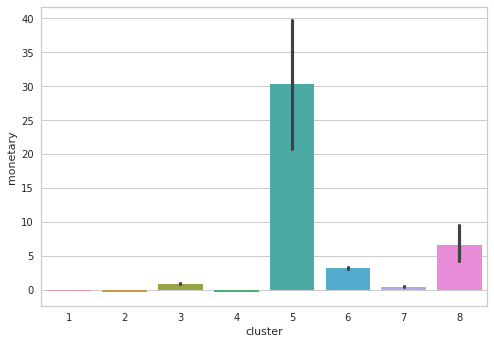

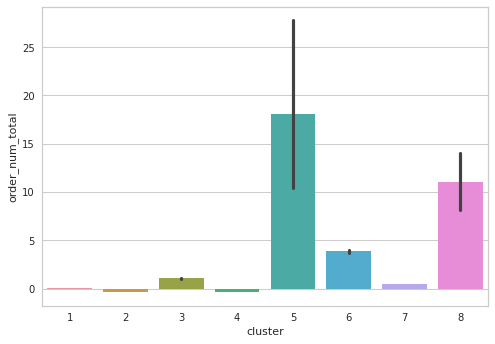

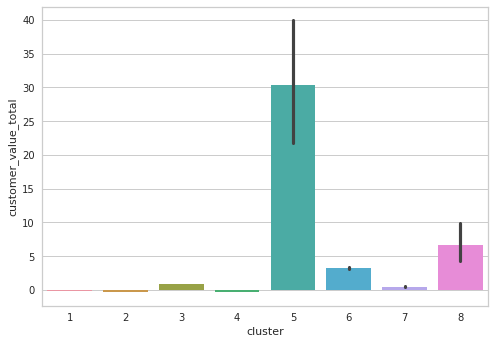

In [27]:
for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

# 6. Hierarchical Clustering

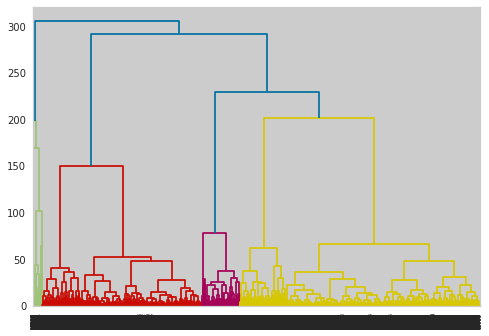

In [28]:
linkage_matrix = linkage(X, method='ward')

dend = dendrogram(linkage_matrix)

plt.show()

In [29]:
hc_average = linkage(X, "average")  
hc_ward = linkage(X, "ward")  
hc_complete = linkage(X, "complete")  
hc_single = linkage(X, "single")  
hc_centroid = linkage(X, "centroid") 

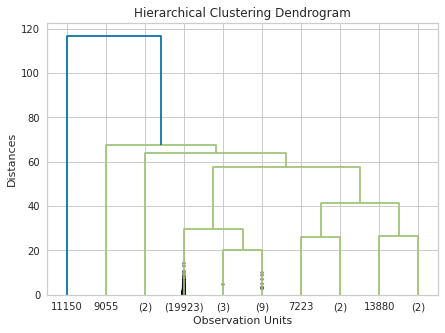

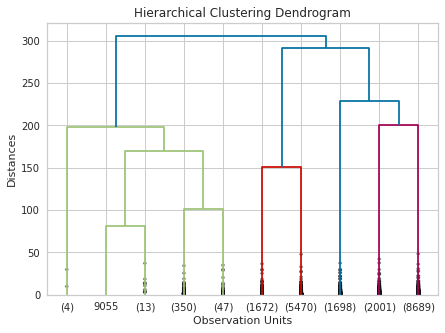

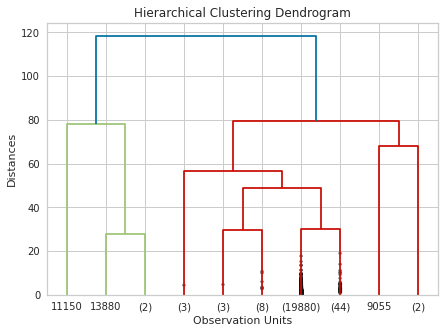

In [30]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_ward,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

In [31]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(X)
clusters_hc

X['cluster_hc'] = clusters_hc
X['cluster_hc'] = X['cluster_hc'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster,cluster_hc
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,4,1
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,6,2
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,2,3
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,4,1
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,4,1


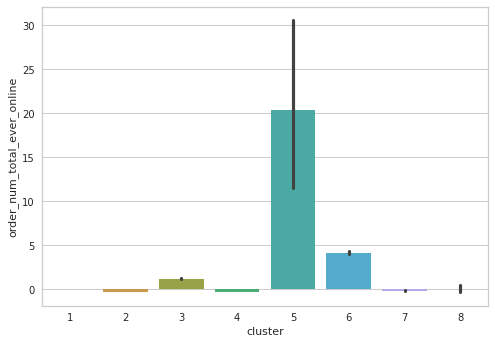

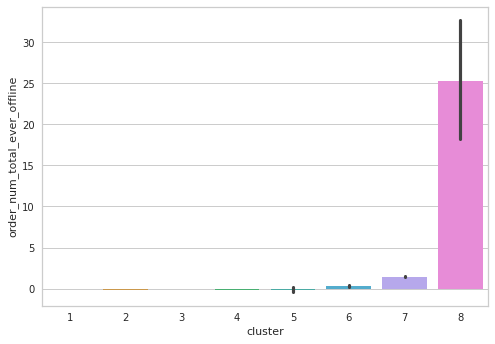

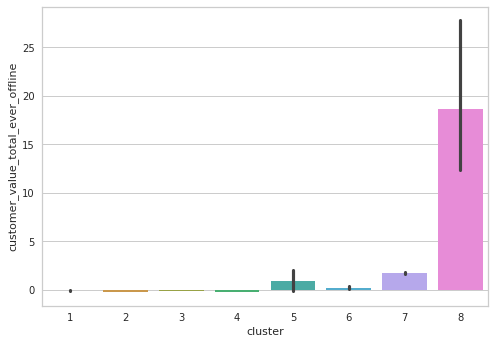

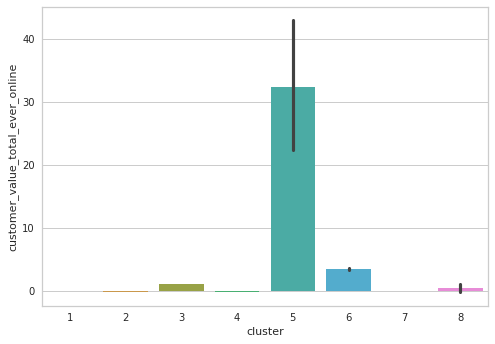

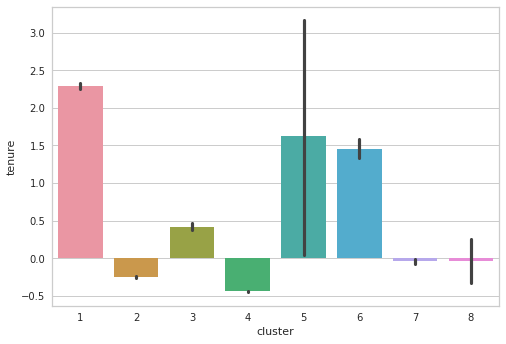

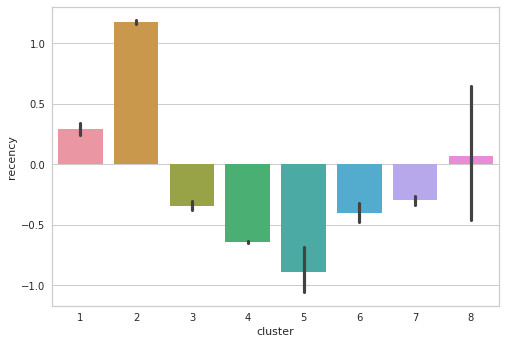

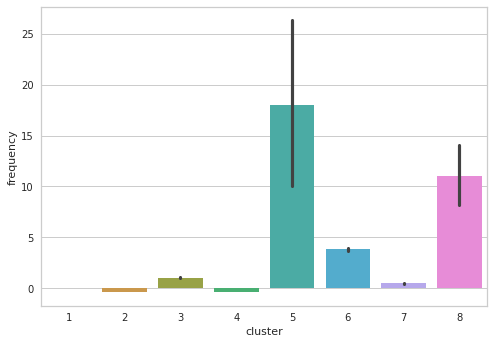

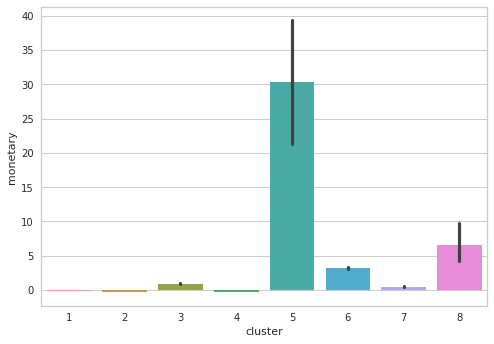

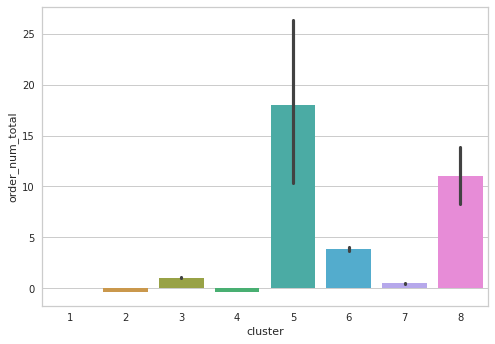

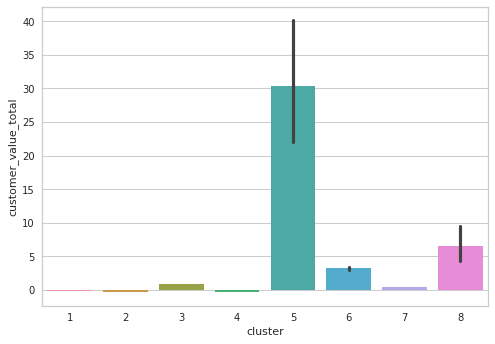

In [32]:
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std']).T

for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

# 7. DBSCAN

In [33]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15)
clusters = dbscan.fit_predict(X)
print(clusters)
df['dbscan_cluster'] = clusters
df.head()

[ 0 -1  1 ...  0  2  1]


,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_num_total,customer_value_total,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline,dbscan_cluster
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],793,674,5.0,939.37,5.0,939.37,0,0,0,0,0,0,1,0
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2153,684,21.0,2013.55,21.0,2013.55,0,0,0,0,0,1,0,-1
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",1131,765,5.0,585.32,5.0,585.32,0,0,0,0,0,0,0,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",725,714,2.0,121.97,2.0,121.97,0,0,0,0,0,0,0,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],1247,665,2.0,209.98,2.0,209.98,1,0,0,1,0,0,0,0


In [34]:
X['cluster_dbscan'] = clusters
X['cluster_dbscan'] = X['cluster_dbscan'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster,cluster_hc,cluster_dbscan
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,4,1,1
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,6,2,0
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,2,3,2
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,4,1,1
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,4,1,1


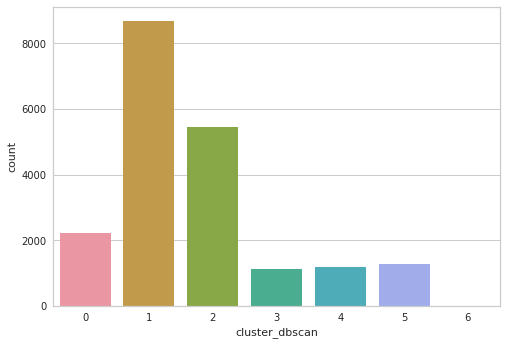

In [35]:
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std']).T

sns.countplot(x='cluster_dbscan', data=X)
plt.show()